# Visual Question Answering

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-ocr-workshop/blob/edac_meeting/jupyter/SparkOcrVisualQuestionAnswering-EDAC.ipynb)

In [ ]:
import os
import sys

secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.12/"

AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""


if AWS_ACCESS_KEY_ID != "":
    os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
    os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY
    
if license:
    os.environ['JSL_OCR_LICENSE'] = license
    
if 'google.colab' in sys.modules:
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

In [2]:
import pyspark
import sparkocr
import json
import os

from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f

from sparkocr.transformers import *
from sparkocr.utils import display_images
from sparkocr.enums import *

### Initialize Spark session

In [3]:
from sparkocr import start
from pyspark import SparkConf

spark = start(jar_path = spark_ocr_jar_path)
#spark = start(secret=secret)
spark

Spark version: 3.2.1
Spark NLP version: 4.4.0
Spark NLP for Healthcare version: 4.3.0
Spark OCR version: 4.4.1rc1



## Load test images

In [4]:
import pkg_resources
test_image_path = "ForemanPage2.jpg"
bin_df = spark.read.format("binaryFile").load(test_image_path)
bin_df.show()

+--------------------+--------------------+-------+--------------------+
|                path|    modificationTime| length|             content|
+--------------------+--------------------+-------+--------------------+
|file:/home/jose/s...|2023-04-24 15:30:...|1094242|[FF D8 FF E0 00 1...|
+--------------------+--------------------+-------+--------------------+



### Display image


    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/ForemanPage2.jpg
    Resolution: 300 dpi
    Width: 2546 px
    Height: 3238 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


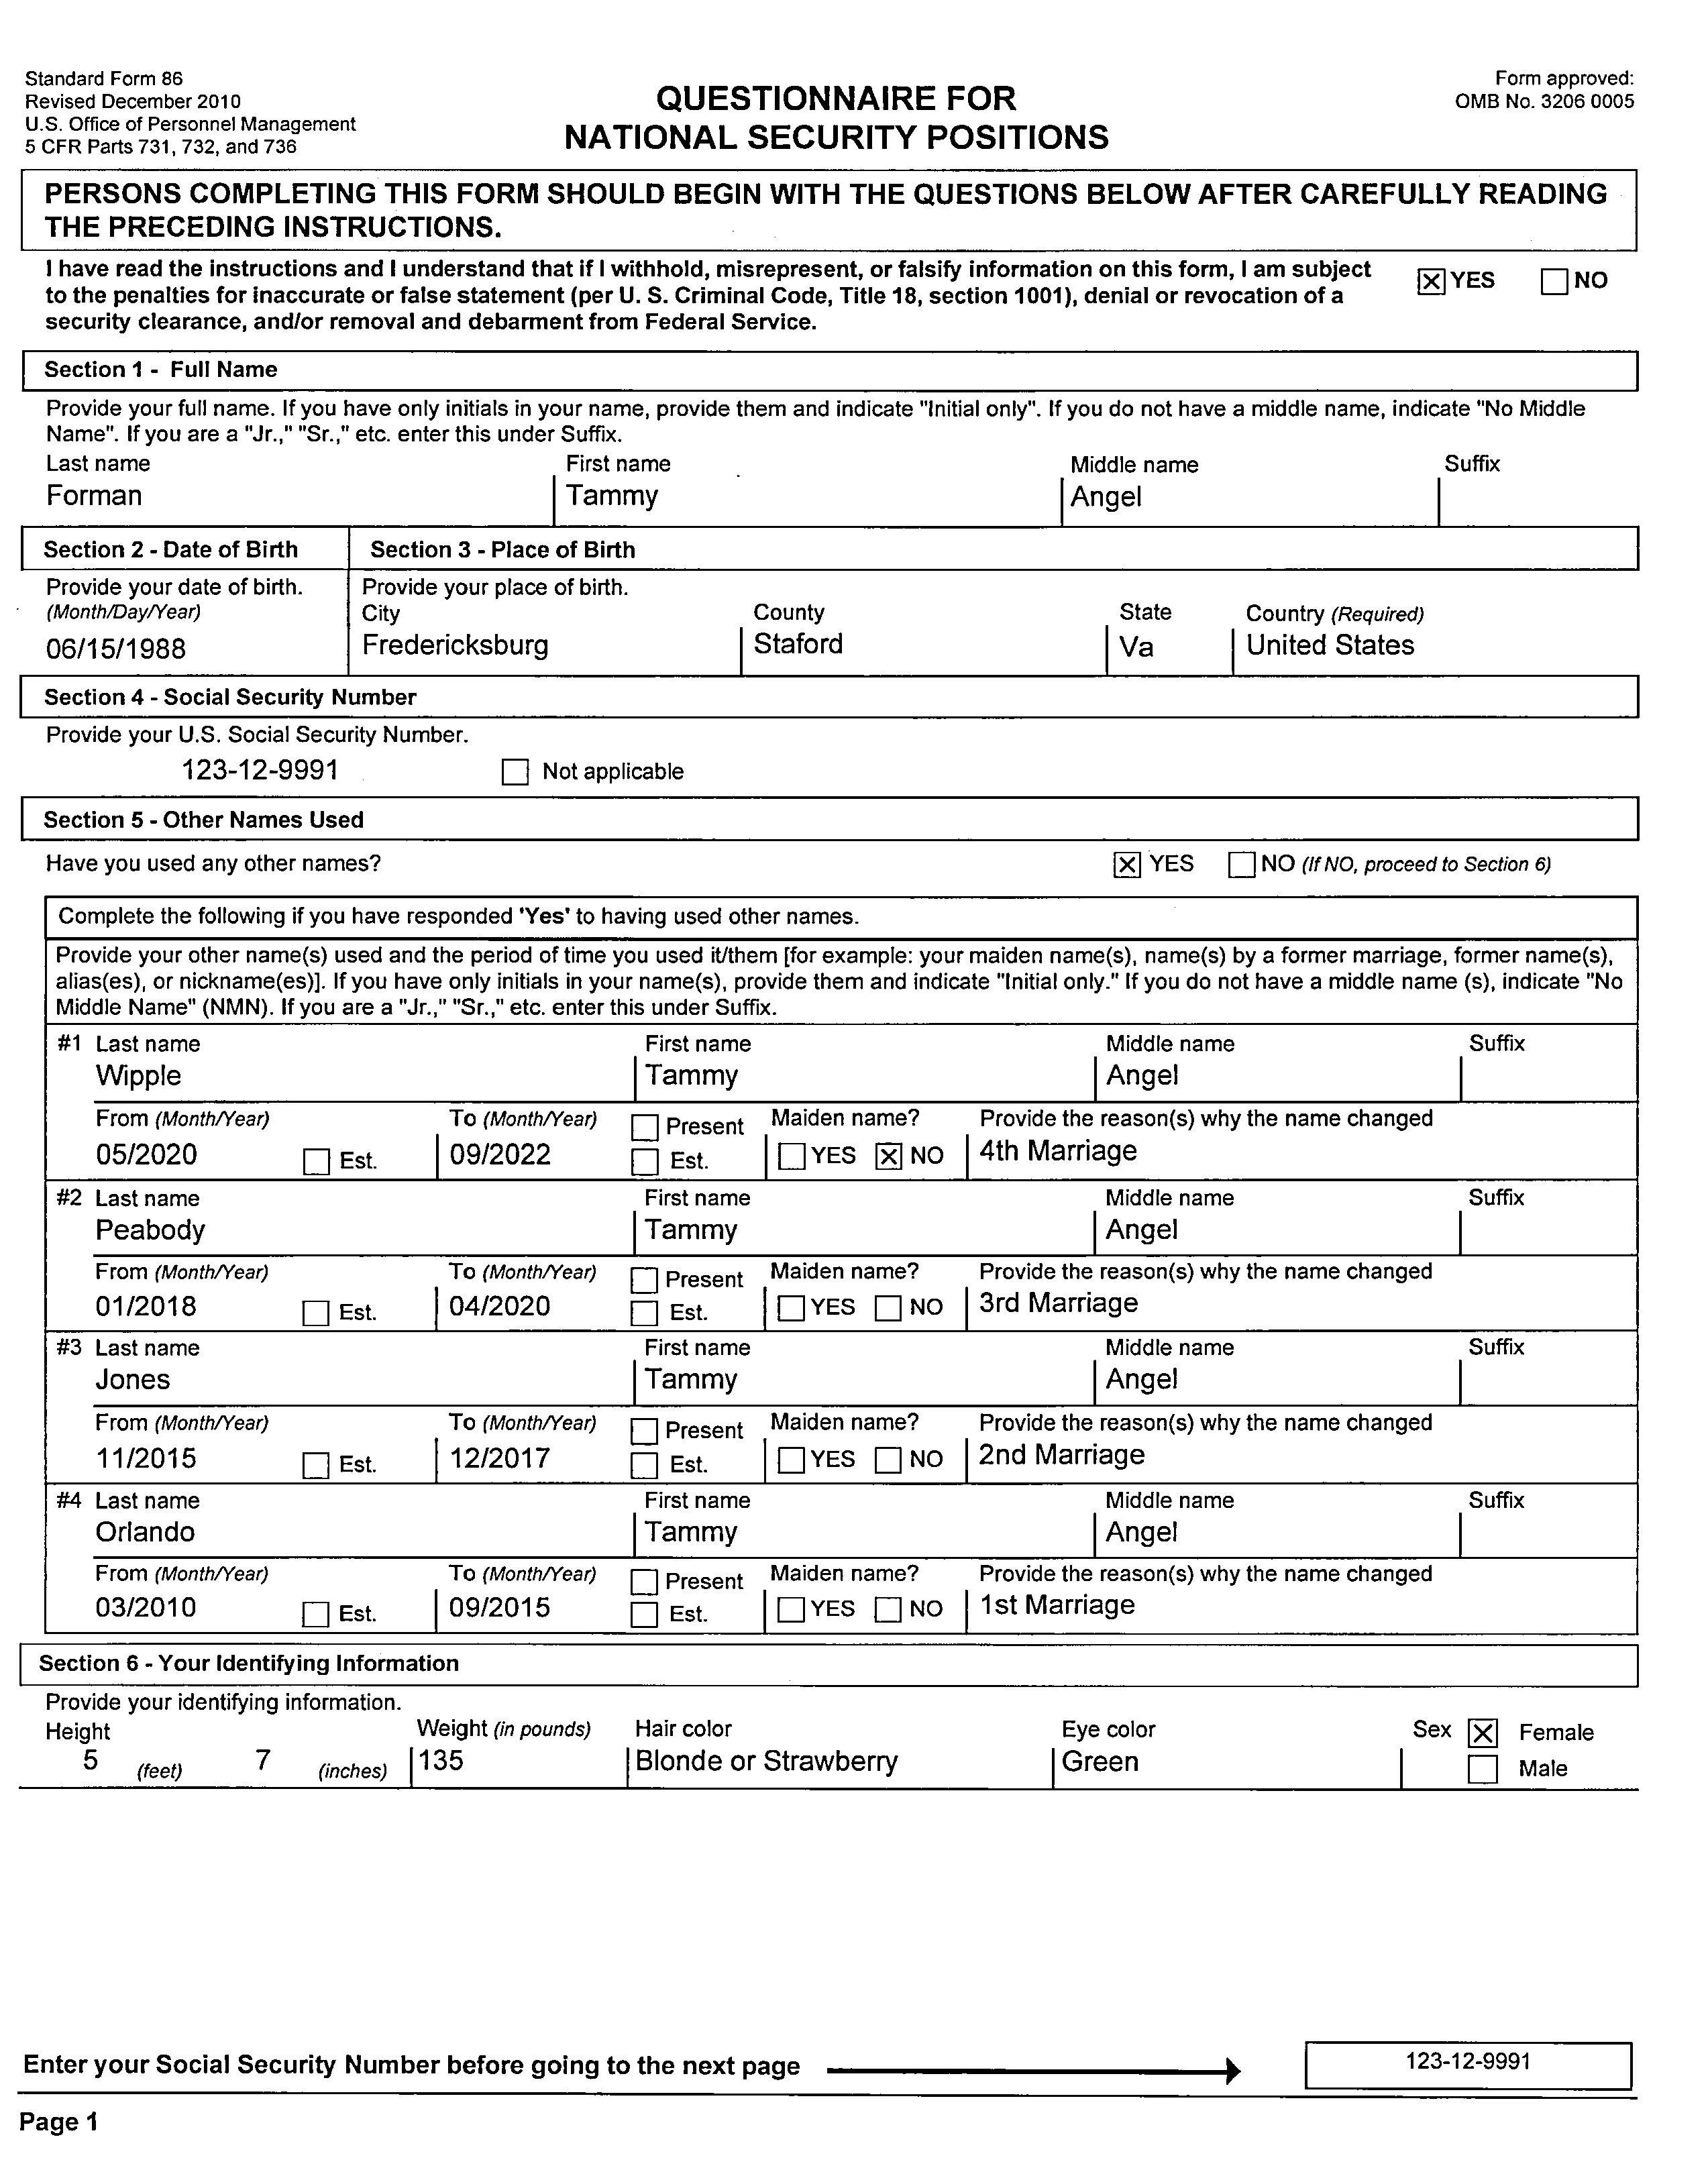

In [5]:
image_df = BinaryToImage().transform(bin_df)
display_images(image_df)

### Add some questions!

In [25]:
questions = [["what is the last name?",
              "what is the first name?",
              "what is the middle name?",
              "What is the city mentioned in section 3?",
              "what is the city where the person was born?",
              "what is the sex mentioned in the form?",
              "Has the person used any other name?",
              "What is the person's eye color?"]]

questions_df = spark.createDataFrame([questions])
questions_df = questions_df.withColumnRenamed("_1", "questions")

In [26]:
image_and_questions = bin_df.join(questions_df)
image_and_questions

path,modificationTime,length,content,questions
file:/home/jose/s...,2023-04-24 15:30:...,1094242,[FF D8 FF E0 00 1...,[what is the last...


### Define pipeline

In [8]:
binary_to_image = BinaryToImage()\
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

visual_question_answering = VisualQuestionAnswering()\
    .pretrained("docvqa_donut_base_opt", "en", "clinical/ocr")\
    .setInputCol(["image"])\
    .setOutputCol("answers")\
    .setQuestionsCol("questions")

# OCR pipeline
pipeline = PipelineModel(stages=[
    binary_to_image,
    visual_question_answering
])

## Call pipeline

In [27]:
%%time
from pyspark.sql.functions import explode
results = pipeline.transform(image_and_questions).cache()
results.select(results.answers).show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|answers                                                                                                                                                                                                                                                                                                                                                                                    |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Apply single set of questions to images across all rows/images

In [6]:
binary_to_image = BinaryToImage()\
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

visual_question_answering = VisualQuestionAnswering()\
    .pretrained("docvqa_donut_base_opt", "en", "clinical/ocr")\
    .setQuestions(questions[0])\
    .setOutputCol("answers")

# OCR pipeline
pipeline = PipelineModel(stages=[
    binary_to_image,
    visual_question_answering
])

In [8]:
%%time
from pyspark.sql.functions import explode
results = pipeline.transform(bin_df)
results.select("answers").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|answers                                                                                                                                                                                                    |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[ When is the Coffee Break? ->  11:34 to 11:39 a.m.,  Who is giving the Introductory Remarks? ->  lee a. waller, trrf vice presi- ident,  Who is going to take part of the individual interviews? ->  trrf]|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## LightPipelines

In [7]:
from sparkocr.base import LightPipeline
lp = LightPipeline(pipeline)

In [9]:
%%time
lp.fromLocalPath(test_image_path)

CPU times: user 10.4 ms, sys: 3.4 ms, total: 13.8 ms
Wall time: 30.1 s


[{'image': [ImageOutput(path: agenda.png, exception: None)],
  'answers': [AnswersOutput(questions_and_answers: [ When is the Coffee Break? ->  11:34 to 11:39 a.m.,  Who is giving the Introductory Remarks? ->  lee a. waller, trrf vice presi- ident,  Who is going to take part of the individual interviews? ->  trrf])]}]